
# CAPTCHA Generator: Classical Compositor + Conditional DCGAN

This notebook accepts a **string** and outputs a **CAPTCHA image** using two methods:
1) **Classical**: sample segmented character assets + augment + compose.
2) **cGAN**: train a conditional DCGAN to generate character sprites, then compose.

**Expected data structure** (confirmed):
```
chars_by_class/
 ├── 0/
 ├── 1/
 ├── 2/
 ├── ...
 ├── a/
 │   ├── A_cap/
 │   └── a_small/
 ├── b/
 │   ├── B_cap/
 │   └── b_small/
 ├── j/        # no cap/small subfolders if visually identical
 └── ...
```


## 1. Setup & Imports

In [13]:

# %pip install torch torchvision opencv-python pillow matplotlib tqdm

import os, random, string
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


## 2. Scan Dataset & Build Token Map

In [14]:
DATA_ROOT = Path("data\chars_by_class")  # main root

DIGITS_DIR = DATA_ROOT / "digits"
LETTERS_DIR = DATA_ROOT / "letters"

def scan_dataset(root: Path):
    assets: Dict[str, List[Path]] = {}
    token_meta: Dict[str, dict] = {}

    # ----- Digits -----
    for ddir in (DIGITS_DIR.iterdir() if DIGITS_DIR.exists() else []):
        if ddir.is_dir():
            d = ddir.name
            paths = [p for p in ddir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            if paths:
                assets[d] = paths
                token_meta[d] = {"kind": "digit", "char": d, "source": str(ddir)}

    # ----- Letters -----
    for ldir in (LETTERS_DIR.iterdir() if LETTERS_DIR.exists() else []):
        if not ldir.is_dir():
            continue
        ch = ldir.name
        cap_dir = ldir / f"{ch.upper()}_cap"
        small_dir = ldir / f"{ch}_small"
        files_direct = [p for p in ldir.glob("*") if p.is_file() and p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]

        if cap_dir.is_dir() and small_dir.is_dir():
            cap_paths = [p for p in cap_dir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            sm_paths  = [p for p in small_dir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            if cap_paths:
                token = f"{ch.upper()}_cap"
                assets[token] = cap_paths
                token_meta[token] = {"kind":"letter_case","char":ch,"case":"cap","source":str(cap_dir)}
            if sm_paths:
                token = f"{ch}_small"
                assets[token] = sm_paths
                token_meta[token] = {"kind":"letter_case","char":ch,"case":"small","source":str(small_dir)}
        else:
            if files_direct:
                token = ch
                assets[token] = files_direct
                token_meta[token] = {"kind":"letter_single","char":ch,"source":str(ldir)}

    # ----- Mapping -----
    idx_to_token = sorted(assets.keys())
    token_to_idx = {t: i for i, t in enumerate(idx_to_token)}

    print(f"Found {len(idx_to_token)} tokens/classes.")
    for t in idx_to_token[:20]:
        print(" ", t, "->", len(assets[t]), "images")
    if len(idx_to_token) > 20:
        print(" ...")
    return assets, token_meta, token_to_idx, idx_to_token

ASSETS, TOKEN_META, TOKEN_TO_IDX, IDX_TO_TOKEN = scan_dataset(DATA_ROOT)


Found 54 tokens/classes.
  0 -> 1301 images
  1 -> 1333 images
  2 -> 1237 images
  3 -> 1335 images
  4 -> 1300 images
  5 -> 1262 images
  6 -> 1297 images
  7 -> 1253 images
  8 -> 1271 images
  9 -> 1292 images
  A_cap -> 577 images
  B_cap -> 659 images
  C_cap -> 1175 images
  D_cap -> 587 images
  E_cap -> 537 images
  F_cap -> 610 images
  G_cap -> 593 images
  H_cap -> 592 images
  I_cap -> 863 images
  L_cap -> 289 images
 ...


## 3. Utils: Image I/O & Viz

### 3.1 Global Configuration

In [ ]:
# Global hyperparameters for cGAN training and generation
IMG_SIZE = 48
NC = 1          # number of channels (grayscale)
NZ = 96         # latent dimension
NGF = 64        # generator base filters
NDF = 64        # discriminator base filters
BATCH_SIZE = 128
EMBED_DIM = 64  # embedding dimension for class conditioning
NCLASS = len(TOKEN_TO_IDX)  # will be set after scanning dataset

print(f"Configuration: IMG_SIZE={IMG_SIZE}, NZ={NZ}, NCLASS={NCLASS}")

In [15]:

def load_rgba(path: Path) -> Image.Image:
    return Image.open(path).convert("RGBA")

def show_image(im: Image.Image, title=None, size=None):
    plt.figure()
    if size: im = im.resize(size, Image.NEAREST)
    plt.imshow(im)
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

def pick_token_for_char(ch: str) -> str:
    if ch.isdigit():
        if ch in ASSETS: return ch
        raise KeyError(f"No assets for digit {ch}")
    if ch.isalpha():
        l = ch.lower()
        cap = f"{l.upper()}_cap"
        small = f"{l}_small"
        if ch.isupper():
            if cap in ASSETS: return cap
            if l in ASSETS: return l
            if small in ASSETS: return small
        else:
            if small in ASSETS: return small
            if l in ASSETS: return l
            if cap in ASSETS: return cap
    raise KeyError(f"No asset token for '{ch}'")


## 4. Classical Compositional Generator

In [16]:
def add_padding(im: Image.Image, pad_x_ratio=0.25, pad_y_ratio=0.05, color=(255,255,255,255)):
    """
    Add horizontal/vertical padding around a character image.
    pad_x_ratio: fraction of width to pad each side (0.25 → 25% left/right)
    pad_y_ratio: fraction of height to pad each side (0.05 → 5% top/bottom)
    color: background fill (white with full alpha)
    """
    w, h = im.size
    px, py = int(w * pad_x_ratio), int(h * pad_y_ratio)
    new_w, new_h = w + 2 * px, h + 2 * py
    new_img = Image.new("RGBA", (new_w, new_h), color)
    new_img.paste(im, (px, py))
    return new_img

In [17]:

def sample_char_image(token: str) -> Image.Image:
    p = random.choice(ASSETS[token])
    return load_rgba(p)

def random_rotation(im: Image.Image, max_deg=0):
    ang = random.uniform(-max_deg, max_deg)
    return im.rotate(ang, resample=Image.BICUBIC, expand=True)

def random_perspective(im: Image.Image, max_warp=0.12):
    # Simple affine approximation using PIL's transform with QUAD mapping
    w, h = im.size
    dx = int(w*max_warp)
    dy = int(h*max_warp)
    src = (0,0, w,0, w,h, 0,h)
    dst = (
        random.randint(-dx, dx), random.randint(-dy, dy),
        w+random.randint(-dx, dx), random.randint(-dy, dy),
        w+random.randint(-dx, dx), h+random.randint(-dy, dy),
        random.randint(-dx, dx),   h+random.randint(-dy, dy)
    )
    return im.transform((w,h), Image.QUAD, dst, resample=Image.BICUBIC)

def random_blur(im: Image.Image, p=0.35):
    if random.random()<p:
        return im.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3,1.2)))
    return im

def add_occlusions(im: Image.Image, p_line=0.6, p_dots=0.5):
    im = im.copy()
    draw = ImageDraw.Draw(im)
    w,h = im.size
    if random.random()<p_line:
        for _ in range(random.randint(1,3)):
            x1,y1 = random.randint(0,w),random.randint(0,h)
            x2,y2 = random.randint(0,w),random.randint(0,h)
            col = (random.randint(0,180),random.randint(0,180),random.randint(0,180),random.randint(90,170))
            draw.line((x1,y1,x2,y2), fill=col, width=random.randint(1,2))
    if random.random()<p_dots:
        for _ in range(random.randint(20,60)):
            x,y = random.randint(0,w),random.randint(0,h)
            r = random.randint(0,1)
            col = (random.randint(0,180),random.randint(0,180),random.randint(0,180),random.randint(90,170))
            draw.ellipse((x-r,y-r,x+r,y+r), fill=col)
    return im

def compose_line(images: List[Image.Image], spacing=(6,20), vjitter=(-3,6), bg=(255,255,255)):
    heights = [im.size[1] for im in images]
    max_h = max(heights)+8
    gaps = [random.randint(*spacing) for _ in range(len(images)-1)]
    total_w = sum(im.size[0] for im in images)+sum(gaps)
    canvas = Image.new("RGBA",(total_w,max_h), bg+(255,))
    x=0
    for i,im in enumerate(images):
        y = random.randint(*vjitter)
        canvas.paste(im,(x,max(0,y)),im)
        x += im.size[0]
        if i<len(images)-1: x += gaps[i]
    return canvas

def classical_generate(text: str, size=(48,48), augment=False, bg=(255,255,255)):
    ims=[]
    for ch in text:
        token = pick_token_for_char(ch)
        im = sample_char_image(token).resize(size, Image.BICUBIC)
        im = add_padding(im, 1, 0.05)
        if augment:
            im = random_rotation(im, 18)
            im = random_perspective(im, 0.04)
            im = random_blur(im, 0.25)
        ims.append(im)
    out = compose_line(ims, spacing=(6,20), vjitter=(-3,6), bg=bg)
    out = add_occlusions(out, 0.6, 0.5)
    out = random_blur(out, 0.25).convert("RGB")
    return out

# # Demo (requires data):
# img = classical_generate("Ab9X2")
# show_image(img, "Classical")


## 5. Conditional DCGAN (per-character)

### 5.0 Important: Data Normalization

**Critical:** The `CharSpriteDataset` must normalize images to `[-1, 1]` to match the Generator's `tanh` output.

The dataset already does this with `T.Normalize([0.5], [0.5])`, which transforms `[0,1] → [-1,1]`.

**Verify your data:**
- Dataset outputs: `shape=[B,1,H,W]`, `range=[-1,1]`
- Generator outputs: `shape=[B,1,H,W]`, `range=[-1,1]` (via tanh)

In [ ]:
# =====================================================
# Dataset for training cGAN
# =====================================================
class CharSpriteDataset(Dataset):
    def __init__(self, assets: Dict[str, List[Path]], token_to_idx: dict, 
                 image_size=48, grayscale=True, normalize=True):
        self.samples = []
        for token, paths in assets.items():
            idx = token_to_idx[token]
            for p in paths:
                self.samples.append((p, idx))
        
        self.image_size = image_size
        self.grayscale = grayscale
        self.normalize = normalize
        
        transforms = [T.Resize((image_size, image_size)), T.ToTensor()]
        if normalize:
            transforms.append(T.Normalize([0.5], [0.5]))  # to [-1, 1]
        self.transform = T.Compose(transforms)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('L' if self.grayscale else 'RGB')
        img = self.transform(img)
        return img, label

In [ ]:
# =====================================================
# MODEL BLOCK: Conditional WGAN-GP with ResNet blocks
# =====================================================
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

class SelfAttention(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.f = SN(nn.Conv2d(ch, ch//8, 1))
        self.g = SN(nn.Conv2d(ch, ch//8, 1))
        self.h = SN(nn.Conv2d(ch, ch, 1))
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        B,C,H,W = x.shape
        f = self.f(x).view(B, -1, H*W)
        g = self.g(x).view(B, -1, H*W)
        attn = F.softmax(torch.bmm(f.permute(0,2,1), g), dim=-1)
        h = self.h(x).view(B, -1, H*W)
        out = torch.bmm(h, attn).view(B,C,H,W)
        return self.gamma * out + x

class ResBlockG(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.c1 = SN(nn.Conv2d(in_ch, out_ch, 3, 1, 1))
        self.c2 = SN(nn.Conv2d(out_ch, out_ch, 3, 1, 1))
        self.bn1, self.bn2 = nn.BatchNorm2d(in_ch), nn.BatchNorm2d(out_ch)
        self.skip = SN(nn.Conv2d(in_ch, out_ch, 1, 1, 0)) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        skip = self.skip(self.up(x))
        y = self.up(x)
        y = F.relu(self.bn1(y))
        y = self.c1(y)
        y = F.relu(self.bn2(y))
        y = self.c2(y)
        return y + skip

class ResBlockD(nn.Module):
    def __init__(self, in_ch, out_ch, down=True):
        super().__init__()
        self.down = down
        self.c1, self.c2 = SN(nn.Conv2d(in_ch, out_ch, 3, 1, 1)), SN(nn.Conv2d(out_ch, out_ch, 3, 1, 1))
        self.skip = SN(nn.Conv2d(in_ch, out_ch, 1, 1, 0)) if in_ch != out_ch else nn.Identity()
        self.avg = nn.AvgPool2d(2) if down else nn.Identity()
    def forward(self, x):
        skip = self.avg(self.skip(x))
        y = F.leaky_relu(self.c1(x), 0.2, inplace=True)
        y = F.leaky_relu(self.c2(y), 0.2, inplace=True)
        y = self.avg(y)
        return y + skip

class Generator(nn.Module):
    def __init__(self, z_dim, nclass, base=64, im_size=48, embed_dim=64):
        super().__init__()
        self.embed = nn.Embedding(nclass, embed_dim)
        self.fc = nn.Linear(z_dim + embed_dim, base*8*4*4)
        self.b1 = ResBlockG(base*8, base*4)
        self.b2 = ResBlockG(base*4, base*2)
        self.b3 = ResBlockG(base*2, base)
        self.sa  = SelfAttention(base)
        self.b4 = ResBlockG(base, base)
        self.to_rgb = SN(nn.Conv2d(base, 1, 3, 1, 1))
        self.im_size = im_size
    def forward(self, z, y):
        yemb = self.embed(y)
        x = torch.cat([z, yemb], 1)
        x = self.fc(x).view(x.size(0), -1, 4, 4)
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.sa(x); x = self.b4(x)
        x = torch.tanh(self.to_rgb(F.relu(x)))
        if x.shape[-1] != self.im_size:
            x = F.interpolate(x, size=(self.im_size, self.im_size), mode="bilinear", align_corners=False)
        return x

class Discriminator(nn.Module):
    def __init__(self, nclass, base=64, proj_scale=0.1):
        super().__init__()
        self.b1 = ResBlockD(1, base)
        self.b2 = ResBlockD(base, base*2)
        self.sa  = SelfAttention(base*2)
        self.b3 = ResBlockD(base*2, base*4)
        self.b4 = ResBlockD(base*4, base*8)
        self.lin = SN(nn.Linear(base*8, 1))
        self.embed = nn.Embedding(nclass, base*8)
        self.proj_scale = proj_scale
        
        # smaller init for embedding helps too
        nn.init.normal_(self.embed.weight, std=0.02)
        
    def forward(self, x, y, return_feat=False):
        h = self.b1(x); h = self.b2(h); h = self.sa(h)
        h = self.b3(h); h = self.b4(h)                 # B, C, 3, 3
        feat = torch.sum(h, dim=(2,3))                 # B, C
        # normalize feature & class embedding → cosine projection, then scale
        feat_n = F.layer_norm(feat, feat.shape[1:])    # LN is more stable than BN here
        emb_n  = F.normalize(self.embed(y), dim=1)
        proj = self.proj_scale * torch.sum(emb_n * feat_n, dim=1)  # B
        out = self.lin(feat).squeeze(1) + proj                      # B
        if return_feat: return out, feat
        return out


### 5.1 Training Loop

In [ ]:
# =====================================================
# TRAINING BLOCK: WGAN-GP + TTUR + Feature Matching
# =====================================================
import torchvision.utils as vutils
from pathlib import Path

def gradient_penalty(D, real, fake, y, device):
    α = torch.rand(real.size(0),1,1,1,device=device)
    inter = (α*real + (1-α)*fake).requires_grad_(True)
    score = D(inter, y)
    grad = torch.autograd.grad(outputs=score, inputs=inter,
                               grad_outputs=torch.ones_like(score),
                               create_graph=True, retain_graph=True, only_inputs=True)[0]
    gp = ((grad.view(grad.size(0), -1).norm(2, dim=1)-1)**2).mean()
    return gp

@torch.no_grad()
def save_vis(G, z_fixed, y_fixed, epoch, save_dir):
    G.eval()
    img = G(z_fixed, y_fixed)
    grid = vutils.make_grid(img, nrow=8, normalize=True, value_range=(-1,1))
    vutils.save_image(grid, f"{save_dir}/vis_{epoch:03d}.png")
    G.train()

def train_wgangp(dl, nclass, z_dim=96, epochs=20, lr_G=1e-4, lr_D=4e-4, base=64, gp_lambda=10, n_critic=5, use_feature_matching=False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G, D = Generator(z_dim, nclass, base).to(device), Discriminator(nclass, base).to(device)
    optG = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(0.0,0.9))
    optD = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(0.0,0.9))
    fixed_z = torch.randn(64, z_dim, device=device)
    fixed_y = torch.tensor([i % nclass for i in range(64)], device=device)
    save_dir = Path("wgan_training"); save_dir.mkdir(exist_ok=True)

    for ep in range(1, epochs+1):
        epoch_D_loss = 0
        epoch_G_loss = 0
        n_batches = 0
        
        for real, y in dl:
            real, y = real.to(device), y.to(device)
            b = real.size(0)
            n_batches += 1
            
            # --- Train D multiple times ---
            for _ in range(n_critic):
                z = torch.randn(b, z_dim, device=device)
                fake = G(z, y).detach()
                D.zero_grad(set_to_none=True)
                real_score = D(real, y)
                fake_score = D(fake, y)
                gp = gradient_penalty(D, real, fake, y, device)*gp_lambda
                loss_D = fake_score.mean() - real_score.mean() + gp
                loss_D.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(D.parameters(), 5.0)
                optD.step()
                
            # Debug output (throttled)
            if n_batches % 50 == 0:
                real_m = real_score.mean().item()
                fake_m = fake_score.mean().item()
                gp_m = gp.item()
                print(f"  [Batch {n_batches}] D: real={real_m:.3f} fake={fake_m:.3f} gp={gp_m:.3f} lossD={loss_D.item():.3f}")
            
            # --- Train G ---
            z = torch.randn(b, z_dim, device=device)
            fake = G(z, y)
            
            if use_feature_matching:
                fake_score, fake_feat = D(fake, y, True)
                with torch.no_grad(): _, real_feat = D(real, y, True)
                fm_loss = F.l1_loss(fake_feat, real_feat) * 10.0
                loss_G = -fake_score.mean() + fm_loss
            else:
                fake_score = D(fake, y)
                loss_G = -fake_score.mean()
            
            G.zero_grad(set_to_none=True)
            loss_G.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(G.parameters(), 5.0)
            optG.step()
            
            epoch_D_loss += loss_D.item()
            epoch_G_loss += loss_G.item()
            
        # Average losses for the epoch
        avg_D_loss = epoch_D_loss / n_batches
        avg_G_loss = epoch_G_loss / n_batches
        
        save_vis(G, fixed_z, fixed_y, ep, save_dir)
        print(f"Epoch {ep:03d} | D: {avg_D_loss:.3f} | G: {avg_G_loss:.3f}")
        torch.save(G.state_dict(), f"{save_dir}/G_ep{ep:03d}.pt")
    print("✅ Training complete.")
    return G


### 5.2 Inference & Unified API

In [ ]:
def load_generator(ckpt_path: str):
    # --- load the upgraded WGAN-GP generator ---
    G = Generator(z_dim=NZ, nclass=NCLASS, base=NGF, im_size=IMG_SIZE).to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    G.load_state_dict(state)
    G.eval()
    return G


def generate_char_with_cgan(G, token: str, size=(48,48)) -> Image.Image:
    y = torch.tensor([TOKEN_TO_IDX[token]], device=DEVICE, dtype=torch.long)
    z = torch.randn(1, NZ, device=DEVICE)
    with torch.no_grad():
        out = G(z, y)  # [-1,1]
    arr = out.squeeze(0).squeeze(0).cpu().numpy()
    arr = (arr*0.5 + 0.5) * 255.0
    arr = arr.clip(0,255).astype(np.uint8)
    pil = Image.fromarray(arr, mode="L").convert("RGBA")
    # crude alpha
    alpha = pil.convert("L").point(lambda v: 255 if v>15 else 0)
    pil.putalpha(alpha)
    if size: pil = pil.resize(size, Image.BICUBIC)
    return pil

def cgan_generate(text: str, G, size=(48,48), augment=True, bg=(255,255,255)):
    ims=[]
    for ch in text:
        token = pick_token_for_char(ch)
        im = generate_char_with_cgan(G, token, size=size)
        if augment:
            im = random_rotation(im, 18)
            im = random_perspective(im, 0.12)
            im = random_blur(im, 0.35)
        ims.append(im)
    out = compose_line(ims, spacing=(6,20), vjitter=(-3,6), bg=bg)
    out = add_occlusions(out, 0.6, 0.5)
    out = random_blur(out, 0.25).convert("RGB")
    return out

class CaptchaGenerator:
    def __init__(self, mode="classical", g_ckpt: Optional[str]=None, bg=(255,255,255)):
        self.mode = mode
        self.bg = bg
        self.G = None
        if mode=="cgan":
            assert g_ckpt and Path(g_ckpt).exists(), "Provide a valid generator checkpoint"
            self.G = load_generator(g_ckpt)
    def generate(self, text: str, size=(48,48), augment=True, save_path: Optional[str]=None) -> Image.Image:
        if self.mode=="classical":
            out = classical_generate(text, size=size, augment=augment, bg=self.bg)
        else:
            out = cgan_generate(text, self.G, size=size, augment=augment, bg=self.bg)
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            out.save(save_path)
        return out


## 6. Traning

In [ ]:
# Create dataset and dataloader
ds = CharSpriteDataset(ASSETS, TOKEN_TO_IDX, image_size=IMG_SIZE, grayscale=True, normalize=True)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# Train the WGAN-GP model
# Start with use_feature_matching=False to isolate issues, then set to True once stable
G = train_wgangp(dl, nclass=NCLASS, z_dim=NZ, epochs=15, base=NGF, 
                 gp_lambda=10, use_feature_matching=False)
torch.save(G.state_dict(), "G_wgangp.pt")

### 6.1 Training Tips & Expected Behavior

**Healthy training signs:**
- `real_mean > fake_mean` by a modest margin (e.g., real=2.5, fake=-1.8)
- `gp ~ 0.5–2.0` (depends on λ, yours is 10)
- `loss_D` should be small positive number (typically 0.5–5.0)
- `loss_G` slowly decreases, no wild swings (±100 is a red flag)

**If still unstable:**
1. Reduce model capacity: `base=32` instead of 64 (often enough for 48×48)
2. Increase GP penalty: `gp_lambda=15` if critic saturates
3. Enable feature matching: `use_feature_matching=True` (after D/G are stable)
4. Verify data: Check that dataset outputs are in `[-1, 1]` range

**Optional: Test data normalization**
```python
# Verify dataset outputs correct range
sample_img, sample_label = ds[0]
print(f"Image shape: {sample_img.shape}, range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")
# Should print: range: [-1.00, 1.00] or close to it
```

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_26172\2233121261.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, mode="L").convert("RGBA")


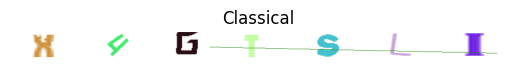

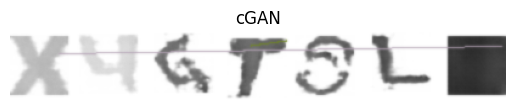

In [ ]:
gen_classical = CaptchaGenerator(mode="classical")
gen_gan = CaptchaGenerator(mode="cgan", g_ckpt="G_wgangp.pt")

gen_str = "x4GTsLI"
img1 = gen_classical.generate(gen_str, augment=False)
img2 = gen_gan.generate(gen_str, augment=False)

show_image(img1, "Classical")
show_image(img2, "WGAN-GP")



## 7. Notes
- If some classes are scarce, consider oversampling or weighted sampling during cGAN training.
- Increase `IMG_SIZE` to 64 and adjust conv stack for more detail.
- You can add elastic warps, shadows, curved baselines in the **whole-canvas** step.
- For fully end-to-end sequence generators (string→image), consider diffusion or transformer-based renderers later; 
  here we keep it robust and practical for your dataset.
